# Tutorial

In [109]:
%matplotlib inline 

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from qubitparameterestimation import model
from qubitparameterestimation import myio

# Table of Contents
* [Using real data](#Using-real-data)
    * [Loading data](#Loading-data)
	* [Generating Fourier coefficients](#Generating-Fourier-coefficients)
	* [Sample inference](#Sample-inference)
* [Evaluating the Adaptive Evolution Time Algorithm](#Evaluating-the-Adaptive-Evolution-Time-Algorithm)
    * [Simulated data](#Simulated-data)
	* [Expected variance](#Expected-variance)
	* [Measurement scheme comparison](#Measurement-scheme-comparison)

# Using real data

## Loading data

Data is loaded as a MetaSeries object that contains the measurement times and measurement outcomes, as well as metadata about the device and long timescale parameters such as $\alpha$, $\beta$, drift, and diffusion. The proper file format is,

=======================================

Device #, $\alpha$, $\beta$ , drift ($\mathrm{kHz/\mu s}$) , diffusion ($\mathrm{kHz^2/\mu s}$)

1, $t_1$, $m_1$

2, $t_2$, $m_2$

3, $t_3$, $m_3$

4, $t_4$, $m_4$

========================================

In [110]:
exampledata = myio.loadData('singleSeries.csv')

## Generating Fourier coefficients

The coefficients are calculated by the update protocol,
$$c_{k+1}(q)=e^{-D(2\pi \tau q)^2\Delta t-i(2\pi \tau q)v\Delta t} \{(1 + m_{k+1}\alpha)c_{k}(q) + m_{k+1}\beta [c_{k}(q+n_{k+1})+ c_{k}(q-n_{k+1})]\}$$

This is implemented by making drift and diffusion vectors indexed by $q$ as well as shifting the $c_k(q)$ vector such that the entire update can be done with vector operations.

In [111]:
coefs = model.getCoefs(exampledata)

## Sample inference

The posterior can be calculated simply by evaluating the Fourier series at various values of $\Delta B_z$. This posterior is generated from the sample data included in the package. It is simulated based on a $\Delta B_z$ which is initially at $60 MHz$ and drifts down in frequency at $25 kHz/\mu s$ as well as diffusing at a rate of $6.7 kHz^2/\mu s$. Note that depending on the number of points used, evaluating the posterior distribution can take a few minutes.

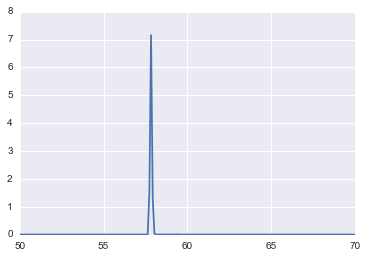

In [112]:
model.posterior(coefs,50,70,200)

As a means of demonstrating the power of the Fourier technique, the expectation value of $\Delta B_z$ can be calculated solely from the Fourier coefficients. This is described in detail in the accompanying paper. In essence, the convolution integral of $\Delta B_z$ and the posterior is just the sum of the product of $\Delta B_z$ and posterior Fourier coefficients. Note how this is can be calculated in a fraction of a second.

In [4]:
model.expectedBz(coefs[99,:],allreal=False)

57.966408573100324

# Evaluating the Adaptive Evolution Time Algorithm

## Simulated data

The most robust way to measure the error would be to implement the scheme and check if the estimated $\Delta B_z$ is more accurate based on whether it increases the coherence time of the qubit. However, most any implementation would have to be programmed on a FPGA if there is any hope of it running within the measurement time of the qubit, approximately 4 $\mathrm{\mu s}$. Short of a way to prove the efficacy using real data, one must rely on simulated data to effectively slow down time and allow an unoptimized algorithm to run. To this end, a time series of simulated $\Delta B_z$ values is generated using specified drift and diffusion coefficients. Based on this series of simulated $\Delta B_z$, a probabilistic measurement can be performed using the current $\Delta B_z$ and the evolution time determined by the measurement scheme. The diffusion of the simulated $\Delta B_z$ is modelled using a random walk.

In [5]:
BzDiffused = model.randomWalk(60,6.7)

## Expected variance

The most important part of the adaptive evolution time algorithm is that the expected variance of the next evolution time can be calculated. As an example, I'll make a simulated data set with linearly increasing evolution times.

In [34]:
c = np.zeros((100,10000))
c[0,0]=1
sequence = np.arange(1,101)

alpha = 0.25
beta = 0.67
drift = 25
diffusion = 6.7*10**12
minMeasureTime = 10*10**(-9)
timePerMeasurement = 4*10**(-6)

diffusionVector = np.array( [np.exp(-diffusion*(i*minMeasureTime)**2*timePerMeasurement) for i in range(c.shape[1])])
m = np.empty(c.shape[0])
for k in range(1,c.shape[0]):
    n = sequence[k]
    m[k] = model.measurementDriftDiffusion(BzDiffused,n*10,0,k)
    cplus = np.concatenate((c[k-1,1:n+1][::-1],c[k-1,:-n]))
    cminus = np.concatenate((c[k-1,n:],c[k-1,-n-1:-1][::-1]))
    c[k,:] = (1+m[k]*alpha)*c[k-1,:]+1/2*m[k]*beta*(cplus+cminus)
    c[k,:] = np.multiply(c[k,:],diffusionVector)

Let's pretend that we have just completed our 50th measurement and want to determine the optimal evolution time for the next measurement. We can evaluated the expected variance for a range of possible evolution times and then just choose the one with the least expected variance.

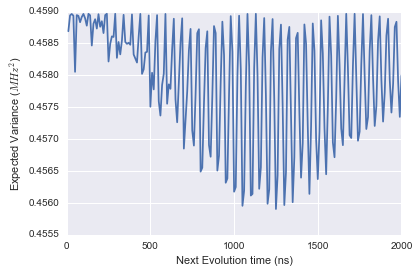

In [106]:
expvars = [model.expVar(c[54,:],i,diffusionVector,.25,.67) for i in range(1,201)]

plt.plot(np.arange(10,2010,10),expvars)
plt.xlabel('Next Evolution time (ns)')
plt.ylabel('Expected Variance ($MHz^2$)')

## Measurement scheme comparison

The first step to calculating the error of our estimates is to run many simulated experiments where the next measurement time is optimized to reduce expected variance. Be aware that this code will take a while to run. In order to recreate the plots like in the paper, coefficients generated from 50 simulated experiments are available as a numpy array (you'll have to unzip it first).

In [ ]:
allCoefsAdaptive = np.empty((100,100,10000))
for i in range(100):
    allCoefsAdaptive[i] = model.optimizedCoefs(100,.25,.67,0,6.7,BzDiffused2)

In [108]:
allCoefsAdaptive = np.load('allCoefsSample.npy')

The same thing can be done to generate experiments with a predetermined sequence of evolution times. The default, as in real life, is 100 linearly increasing evolution times.

In [56]:
allCoefsLinear = np.empty((100,100,10000))
for i in range(100):
    allCoefsStandard[i] = model.simulateCoefs(.25,.67,0,6.7,BzDiffused2)

With these two sets of coefficients from 100 adaptive and 100 linearly spaced experiments, we can calculate the mean squared error of the $\Delta B_z$ estimates as compared to the underlying, "real", $\Delta B_z$. This doesn't take so long, maybe a few minutes, but I'll include the mean squared error values used for my plots as numpy arrays in the repository. In case you haven't actually run the code, I'll just load in the sample $\Delta B_z$ that went along with the simulated experiments. This will look a little noisier than the data in my paper. For that data, I used a different $\Delta B_z$ series for each experiment but with the same initial value and diffusion constant. This helps smooth the noise that originates from large jumps in the underlying $\Delta B_z$

In [75]:
BzDiffused2 = np.load('BzDiffusedSample.npy')

In [101]:
mseAdaptive = np.empty(100)
for i in range(100):
    expBz = [model.expectedBz(allCoefsAdaptive[j,i,:]) for j in range(allCoefsAdaptive.shape[0])]
    mseAdaptive[i] = np.mean(np.square(np.subtract(expBz,BzDiffused2[4*i])))

In [ ]:
mseLinear = np.empty(100)
for i in range(100):
    expBz = [model.expectedBz(allCoefsLinear[j,i,:]) for j in range(100)]
    mseLinear[i] = np.mean(np.square(np.subtract(expBz,BzDiffused2[4*i])))

In [103]:
mseAdaptive = np.load('mseAdaptive.npy')

In [104]:
mseLinear = np.load('mseLinear.npy')

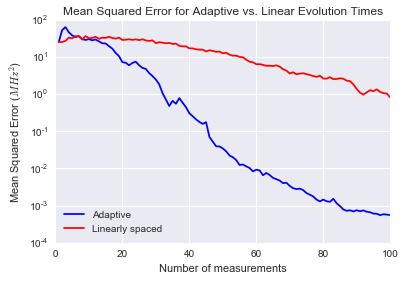

In [105]:
plt.plot(range(1,101),mseAdaptive, 'b', label='Adaptive')
plt.plot(range(1,101),mseLinear, 'r', label='Linearly spaced')

plt.yscale('log')
plt.title('Mean Squared Error for Adaptive vs. Linear Evolution Times')
plt.ylabel('Mean Squared Error ($MHz^2$)')
plt.xlabel('Number of measurements')
plt.legend(loc=3)